<b> Goal: Date-time expansion
- Day of week as an integer, One hot encode 
- Month of year 
- hour of day

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

In [2]:
# Read and format data
path = 'data/combined_data.csv' # change path

df_all = pd.read_csv(path)
df_all.date_time_current = pd.to_datetime(df_all.date_time_current, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_future = pd.to_datetime(df_all.date_time_future, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_current_rounded = pd.to_datetime(df_all.date_time_current_rounded, format = "%Y-%m-%d %H:%M:%S")

df_all["forecast_interval"] = df_all.date_time_future - df_all.date_time_current_rounded
df_all["demand_error"] = df_all.total_demand - df_all.forecast_demand
df_all["demand_error_relative"] = df_all.demand_error / df_all.total_demand

In [3]:
df_all.sample(5)

,id,period_id,forecast_demand,date_time_current,date_time_future,date_time_current_rounded,total_demand,temperature_future,temperature_current,temperature_future_forecast,humidity_future_forecast,dew_point_future_forecast,wind_speed_future_forecast,forecast_interval,demand_error,demand_error_relative
4377266,2014071340,33,9003.51,2014-07-13 23:31:16,2014-07-14 16:00:00,2014-07-13 23:30:00,9359.38,15.1,5.1,NaN,NaN,NaN,NaN,16:30:00,355.87,0.038023
7104249,2017050820,32,6871.51,2017-05-08 13:31:48,2017-05-09 05:30:00,2017-05-08 13:30:00,6910.18,9.6,17.7,NaN,NaN,NaN,NaN,16:00:00,38.67,0.005596
1663021,2011092713,25,8679.84,2011-09-27 10:00:47,2011-09-27 22:30:00,2011-09-27 10:00:00,8567.70,14.8,17.3,NaN,NaN,NaN,NaN,12:30:00,-112.14,-0.013089
8655550,2018121241,3,6777.46,2018-12-13 00:01:13,2018-12-13 01:30:00,2018-12-13 00:00:00,6817.59,21.2,21.2,NaN,NaN,NaN,NaN,01:30:00,40.13,0.005886
10744249,2021020404,18,8238.18,2021-02-04 05:31:10,2021-02-04 14:30:00,2021-02-04 05:30:00,8546.69,26.3,15.9,NaN,NaN,NaN,NaN,09:00:00,308.51,0.036097


In [4]:
# Plots Time Decomposition
def time_decomposition_error_plots(df, x, time_interval,
                                   show_outliers = True, forecast_interval = 12, show_relative_error_all = True, show_relative_error_interval = True):
    if show_relative_error_all:
        plt.figure(figsize = (12,6))
        sns.boxplot(data = df, x = x, y = "demand_error_relative", palette = 'Blues', showfliers = show_outliers)
        plt.grid(alpha = 0.5)
        plt.axhline(0, color='r', alpha = 0.2)
        plt.title("{} vs Relative Demand Error (all forecasts)".format(time_interval));

    if show_relative_error_interval:
        plt.figure(figsize = (12,6))
        sns.boxplot(data = df.loc[df.period_id == forecast_interval*2], 
                    x = x, y = "demand_error_relative", palette = 'Blues', showfliers = show_outliers)
        plt.grid(alpha = 0.5)
        plt.axhline(0, color='r', alpha = 0.2)
        plt.title("{} vs Relative Demand Error ({}h forecasts)".format(time_interval, forecast_interval));

### Day of Week
Notes:
- Demand: Weekends have less demand than weekdays. Sunday has lowest median demand
- Error
    - Median: Sundays are over-forecasted. 
    - Variance: Sunday, Monday, Saturday (in descending order) have highest variance.
    - Outliers: Fridays have large variance (outlier errors).

To improve the forecast, propose adding **isFriday** and **isSunday** as boolean variables.

In [5]:
df_weekday = df_all.copy()
df_weekday["date_time_future_weekday"] = df_weekday.date_time_future.dt.day_name()
df_weekday["date_time_future_weekday_num"] = df_weekday.date_time_future.dt.dayofweek
df_weekday = df_weekday.sort_values("date_time_future_weekday_num")

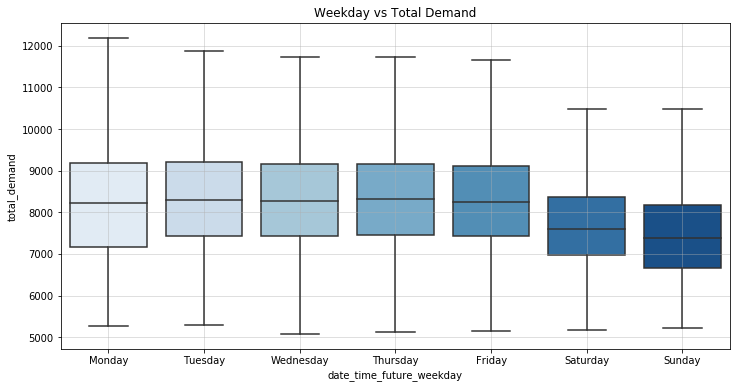

In [6]:
plt.figure(figsize = (12,6))
sns.boxplot(data = df_weekday.groupby("date_time_future", as_index = False).first().sort_values("date_time_future_weekday_num"), 
            x="date_time_future_weekday", y = "total_demand", palette = 'Blues', showfliers = False)
plt.grid(alpha = 0.5)
plt.title("Weekday vs Total Demand");

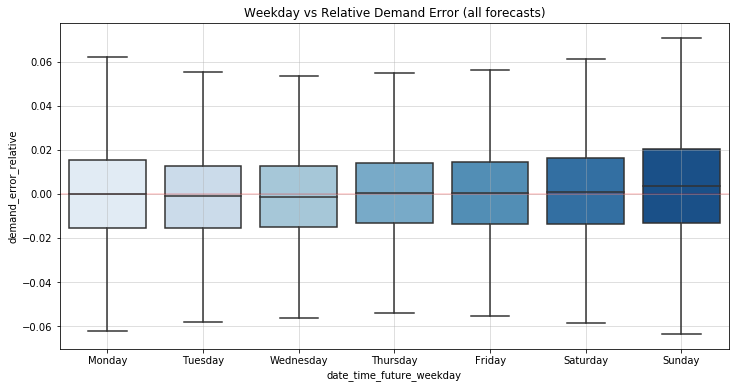

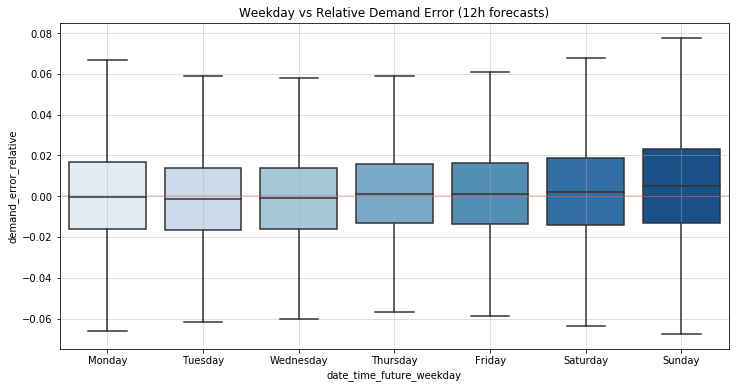

In [7]:
time_decomposition_error_plots(df = df_weekday, x = "date_time_future_weekday", time_interval = "Weekday",
                               show_outliers = False, forecast_interval = 12, show_relative_error_all = True, show_relative_error_interval = True)

### Month of Year
Notes:
- Demand: Seasonality observed in data. Highest demand in winter.
- Error
    - Median: November, December and January have positive forecast error (i.e. under-forecasted)
    - Variance: Seasonality observed in variance.
    - Outliers: February has negative-error outliers (i.e. over-forecasted).  
- Propose adding month booleans. However, this is likely reflected in temperature.

In [8]:
df_month = df_all.copy()
df_month["date_time_future_month"] = df_month.date_time_future.dt.month_name()
df_month["date_time_future_month_num"] = df_month.date_time_future.dt.month
df_month = df_month.sort_values("date_time_future_month_num")

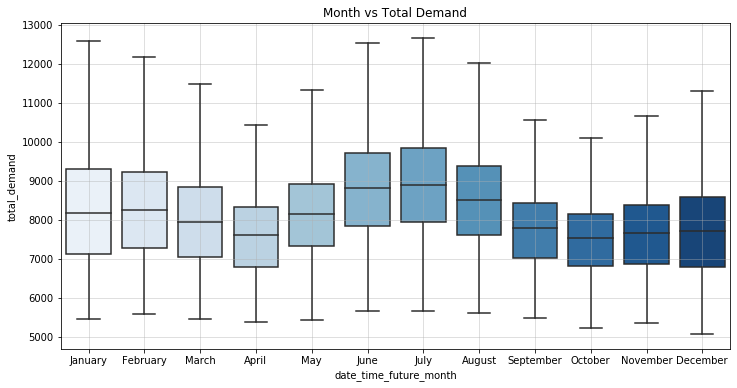

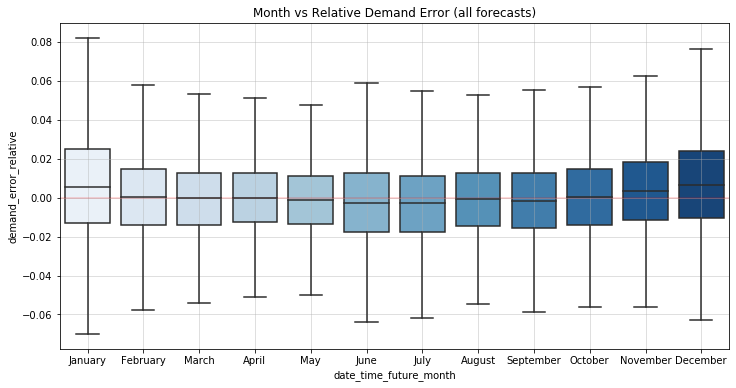

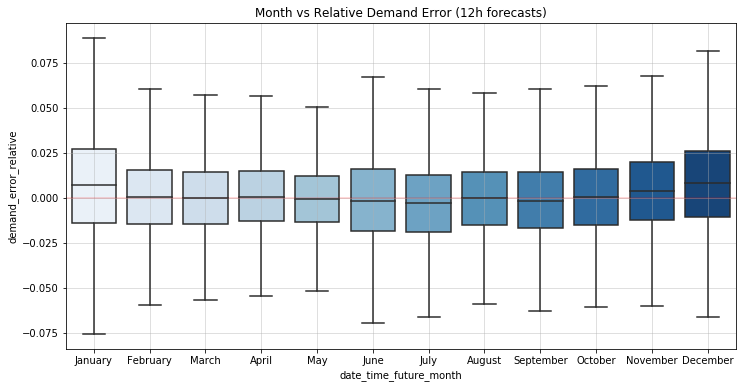

In [9]:
plt.figure(figsize = (12,6))
sns.boxplot(data = df_month.groupby("date_time_future", as_index = False).first().sort_values("date_time_future_month_num"), 
            x="date_time_future_month", y = "total_demand", palette = 'Blues', showfliers = False)
plt.grid(alpha = 0.5)
plt.title("Month vs Total Demand");

time_decomposition_error_plots(df = df_month, x = "date_time_future_month", time_interval = "Month",
                               show_outliers = False, forecast_interval = 12, show_relative_error_all = True, show_relative_error_interval = True)

### Hour of Day
Notes:
- Demand: Median as expected considering a work-day.
- Error
    - Median: Least accurate between 4am - 8am.
    - Variance: Variance highest during work hours.
    - Outliers: Negative outliers between 4pm-8pm.
- Propose adding boolean variable for 4am-8am.

In [10]:
df_hour = df_all.copy()
df_hour["date_time_future_hour"] = df_hour.date_time_future.dt.hour
df_hour = df_hour.sort_values("date_time_future_hour")

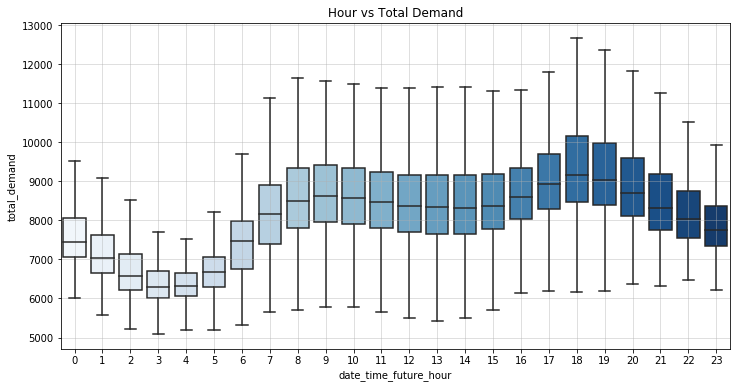

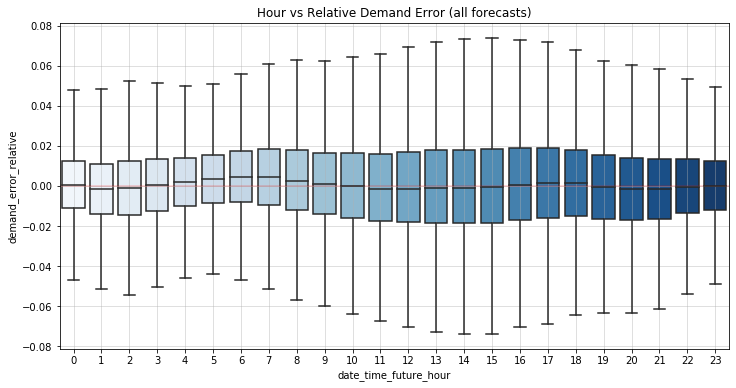

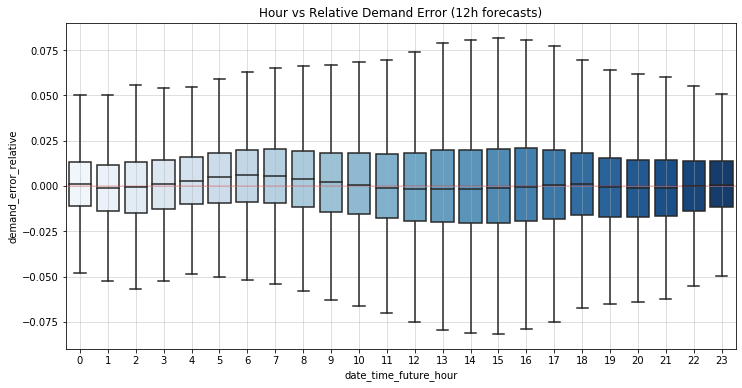

In [11]:
plt.figure(figsize = (12,6))
sns.boxplot(data = df_hour.groupby("date_time_future", as_index = False).first().sort_values("date_time_future_hour"), 
            x="date_time_future_hour", y = "total_demand", palette = 'Blues', showfliers = False)
plt.grid(alpha = 0.5)
plt.title("Hour vs Total Demand");

time_decomposition_error_plots(df = df_hour, x = "date_time_future_hour", time_interval = "Hour",
                               show_outliers = False, forecast_interval = 12, show_relative_error_all = True, show_relative_error_interval = True)

### Year
Notes:
- Demand: 
- Error
    - Median: 
    - Variance: 
    - Outliers: 
- 

In [12]:
df_year = df_all.copy()
df_year["date_time_future_year"] = df_hour.date_time_future.dt.year
df_year = df_year.sort_values("date_time_future_year")

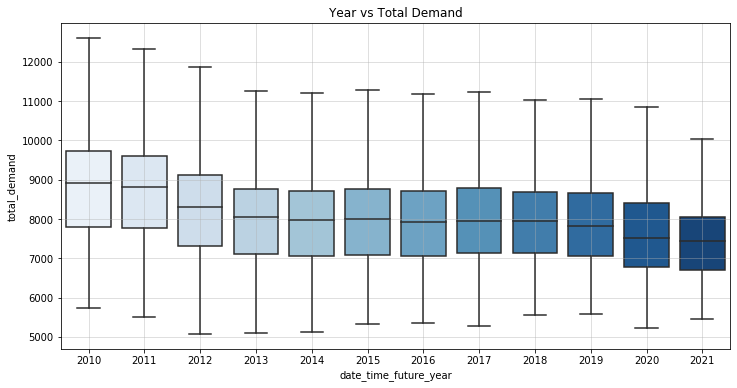

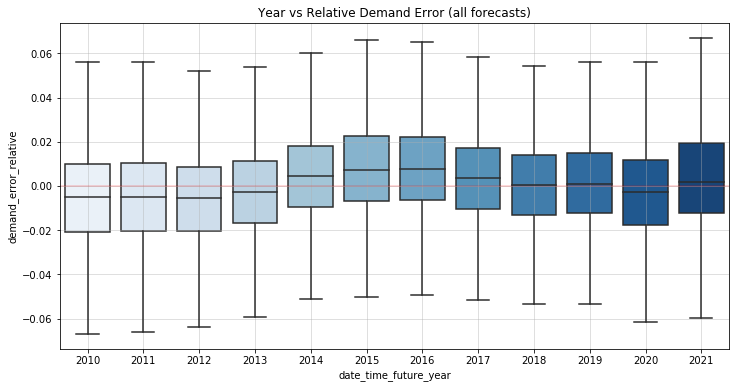

In [18]:
plt.figure(figsize = (12,6))
sns.boxplot(data = df_year.groupby("date_time_future", as_index = False).first().sort_values("date_time_future_year"), 
            x="date_time_future_year", y = "total_demand", palette = 'Blues', showfliers = False)
plt.grid(alpha = 0.5)
plt.title("Year vs Total Demand");

time_decomposition_error_plots(df = df_year, x = "date_time_future_year", time_interval = "Year",
                               show_outliers = False, forecast_interval = 12, show_relative_error_all = True, show_relative_error_interval = False)